#**Optimal Financial Instruments Utilization for Maximization of Stock Buying Power in the Future**

### Function definition for retrieving data and Library Setting

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf
import numpy as np
import cvxpy as cp


def get_current_prices(tickers):
    """
    Fetch the current prices of the given tickers.

    Args:
        tickers (list): List of stock ticker symbols.

    Returns:
        np.array: Array of current prices for the tickers.
    """
    prices = []
    for ticker in tickers:
        try:
            # Fetching the latest market data
            stock = yf.Ticker(ticker)
            price = stock.history(period="1d")['Close'].iloc[-1]  # Get the last closing price
            prices.append(price)
        except Exception as e:
            print(f"Failed to fetch price for {ticker}: {e}")
            prices.append(np.nan)  # Handle missing data gracefully
    return np.array(prices)

#####################
seed = 42
def monte_carlo_simulation(tickers, days=1, scenarios=5, seed=None):
    """
    Monte Carlo simulation for stock prices over a given time horizon.

    Args:
        tickers (list): List of stock ticker symbols.
        days (int): Number of days to simulate (e.g., 5 for a week).
        scenarios (int): Number of Monte Carlo scenarios.
        seed (int or None): Optional seed value for reproducibility.

    Returns:
        np.array: A 2D array where each row corresponds to a stock and
                  each column corresponds to a scenario.
    """
    # Set random seed for reproducibility if specified
    if seed is not None:
        np.random.seed(seed)

    prices = []
    volatilities = []
    returns = []

    # Get current prices and historical data to calculate volatility
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(period="1y")  # Use 1 year of data
            current_price = hist['Close'].iloc[-1]
            prices.append(current_price)

            # Calculate annualized volatility
            daily_returns = hist['Close'].pct_change().dropna()
            volatility = np.std(daily_returns) * np.sqrt(252)  # Annualized
            volatilities.append(volatility)
            returns.append(daily_returns.mean())
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            prices.append(np.nan)
            volatilities.append(np.nan)

    prices = np.array(prices)
    volatilities = np.array(volatilities)
    returns = np.array(returns)

    print(returns,prices,volatilities)
    # Time step
    dt = 1/252  # Daily time step for a year

    # Monte Carlo simulation
    simulated_prices = np.zeros((len(tickers), scenarios))
    for i, (price, vol,returns_i) in enumerate(zip(prices, volatilities,returns)):
        if np.isnan(price) or np.isnan(vol) or np.isnan(returns_i):  # Skip if data is invalid
            simulated_prices[i, :] = np.nan
            continue

        for j in range(scenarios):
            # Generate random price changes over the period
            drift = returns_i-0.5 * vol ** 2 * dt * days  # Simplified drift
            shock = vol * np.sqrt(dt * days) * np.random.normal()
            simulated_price = price * np.exp(drift + shock)
            simulated_prices[i, j] = simulated_price

    return simulated_prices

def format_scenarios(simulated_prices):
    """
    Formats the simulated prices into an array of scenarios.

    Args:
        simulated_prices (np.array): A 2D array where each row corresponds to a stock
                                     and each column corresponds to a scenario.

    Returns:
        list: A list of arrays, each representing the simulated prices for a scenario.
    """
    scenarios = [simulated_prices[:, i] for i in range(simulated_prices.shape[1])]
    return scenarios



    ################################


def get_option_prices(tickers):
    """
    Fetches the first available call and put option prices for each stock.

    Args:
        tickers (list): List of stock ticker symbols.

    Returns:
        tuple: Two lists, `oc` (call prices) and `op` (put prices), and `psp` (strike prices for call options).
    """
    oc = []  # Option call prices
    op = []  # Option put prices
    psp = []  # Strike prices for call options

    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)

            # Get the first available expiration date
            expiration_dates = stock.options
            if not expiration_dates:
                raise ValueError(f"No options available for {ticker}.")
            first_expiration = expiration_dates[1]

            # Fetch the option chain for the first expiration date
            option_chain = stock.option_chain(first_expiration)

            # Get the current stock price
            current_price = stock.history(period="1d").iloc[-1]['Close']

            # Find the first call option with a strike price >= current price
            call_price = None
            strike_price = None
            for _, row in option_chain.calls.iterrows():
                if row['strike'] >= current_price:
                    call_price = row['lastPrice']
                    strike_price = row['strike']
                    break

            if call_price is None or strike_price is None:
                raise ValueError(f"No suitable call options found for {ticker}.")

            # Get the first put price (at the first strike available)
            put_price = option_chain.puts.iloc[0]['lastPrice']

            # Append to the lists
            oc.append(call_price)
            op.append(put_price)
            psp.append(strike_price)

        except Exception as e:
            print(f"Failed to fetch options for {ticker}: {e}")
            oc.append(None)  # Handle missing data gracefully
            op.append(None)
            psp.append(None)

    return oc, psp

#############################################################################

def get_futures_prices(futures_tickers):
    """
    Fetches the latest prices for specified futures tickers.

    Args:
        futures_tickers (list): A list of futures ticker symbols.

    Returns:
        list: A list of dictionaries, each containing a futures ticker and its last price.
    """
    futures_data_list = []

    for ticker in futures_tickers:
        try:
            futures = yf.Ticker(ticker)

            # Get historical data for the past day
            data = futures.history(period="1d")

            if data.empty:
                raise ValueError(f"No historical data available for {ticker}.")

            # Extract the latest closing price
            last_price = data['Close'].iloc[-1]
            futures_data_list.append({"ticker": ticker, "last_price": last_price})

        except Exception as e:
            print(f"Failed to fetch futures data for {ticker}: {e}")

    return futures_data_list

    ###################################################


def pretty_params(rf = 0.0422, mu =0.303, volly  = 0.28 , tickers = ["AAPL", "GOOGL", "MSFT"]):
    rf  = rf
    prices = []
    volatilities = []
    returns = []
    strike_prices  = [330, 240, 595]
    call_prices = [4.15, 12.12, 10.62]
    future_prices = []#[326, 244, 594]
    rois = []
    volat = []
    returnolo = mu
    i = 0
    # Get current prices and historical data to calculate volatility
    simulated_prices = np.zeros((3, 5))

    for ticker in tickers:

        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(period="10y")  # Use 1 year of data
            current_price = hist['Close'].iloc[-1]
            prices.append(current_price)

            # Calculate annualized volatility
            daily_returns = hist['Close'].pct_change().dropna()

            # Calculate the yearly average return
            average_daily_return = daily_returns.mean()  # Mean daily return
            yearly_average_return = (1 + average_daily_return) ** 252 - 1  # Compounded yearly return
            rois.append(yearly_average_return)
            # Calculate yearly average volatility
            daily_volatility = np.std(daily_returns)  # Daily standard deviation
            yearly_average_volatility = daily_volatility * np.sqrt(252)  # Annualized volatility

            exp_price_1y = current_price*(1+yearly_average_return)
            exp_price_1y = current_price*(1+rf)

            future_prices.append(exp_price_1y)
            volat.append(yearly_average_volatility)

            # Calculate the yearly average return
            #scenarios in 365 days
            unord = []
            for j in range(5):
            # Generate random price changes over the period
                drift = returnolo-0.5 * yearly_average_volatility ** 2
                shock = yearly_average_volatility * np.random.normal()
                drift2 = returnolo-0.5 * volly ** 2
                shock2 = volly * np.random.normal()
                simulated_price = current_price * np.exp(drift2 + shock2)
                unord.append(simulated_price)
            unord.sort()
            for j in range(5):
                simulated_price = unord[j]
                simulated_prices[i, j] = simulated_price
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            prices.append(np.nan)
            volatilities.append(np.nan)

        i+=1
    prob = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
    prob = np.array([0.05, 0.25, 0.4, 0.25, 0.05])
    B = 1000000
    N = 3  # Number of assets
    M = 5  # Number of scenarios
    alpha = 0.95  # Confidence level
    simulated_prices = np.array([simulated_prices[:, i] for i in range(simulated_prices.shape[1])]).T

    call_prices = np.array(call_prices)
    strike_prices = np.array(strike_prices)
    future_prices = np.array(future_prices)

    return prices, simulated_prices, call_prices, strike_prices, future_prices, B, N, M, alpha, prob

### Parameter Definition

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

# Parameters
tickers = ["AAPL", "GOOGL", "MSFT"]  # Replace with your tickers
p0 = np.array(get_current_prices(tickers))

prob = np.array([0.2, 0.2, 0.2, 0.2, 0.2]) # Probability of each scenario

# Initialise prices and scenarios
simulated_prices = monte_carlo_simulation(tickers, days=5, scenarios=5)  # (N x M matrix)
p1 = np.array(simulated_prices)
print(p1.shape)
pc, psp = np.array(get_option_prices(tickers))  # Prices of options, etc.
#pc = pc/100
B = 1000000
N = 3  # Number of assets
M = 5  # Number of scenarios
alpha = 0.95  # Confidence level


futures_tickers = ["APC.F", "ABEC.F", "MSF.F"]  # Examples of futures tickers
futures_data = get_futures_prices(futures_tickers)

# Futures prices
pf = np.array([item['last_price'] for item in futures_data])


print(p0)
print(pc)
print(psp)
print(np.mean(p1,axis = 1))
print(futures_data)

[0.00101586 0.00161507 0.00090534] [248.13000488 189.82000732 447.26998901] [0.22398382 0.27579273 0.19458512]
(3, 5)
[248.13000488 189.82000732 447.26998901]
[2.34 3.75 4.64]
[250. 190. 450.]
[250.50915108 190.55815157 435.06463134]
[{'ticker': 'APC.F', 'last_price': 236.1999969482422}, {'ticker': 'ABEC.F', 'last_price': 184.17999267578125}, {'ticker': 'MSF.F', 'last_price': 425.25}]


### Model definition given specific level of Beta

In [ ]:
beta = 0.5

# Define the decision variables
s0 = cp.Variable(N, integer=True)

c = cp.Variable(N, integer=True)

ci  = cp.Variable((N,M), integer=True)

fa  = cp.Variable(N, integer=True)

f0 = cp.Variable(N, integer=True)

f1 = cp.Variable(N, integer=True)

mj = cp.Variable((N,M),  integer=True)

w = cp.Variable(nonneg=True)


ni = cp.Variable(M, nonneg=True)

xi = cp.Variable()

# Objective function

# First term: Weighted expected payoff
inner_sum = cp.sum(cp.multiply(p1, s0[:, None] + mj + ci), axis=0)  # Sum over j for each i
expected_payoff = cp.sum(cp.multiply(prob, inner_sum))  # Sum over i

# Second term: CVaR term
cvar_term = xi - (1 / (1 - alpha)) * cp.sum(cp.multiply(prob, ni))

# Full objective function
objective = cp.Maximize(beta * expected_payoff + (1 - beta) * cvar_term)

budget_constraint = (
    w + cp.sum(cp.multiply(pc, c)) + cp.sum(cp.multiply(f0, p0)) + cp.sum(cp.multiply(s0, p0)) == B
)

contract_constraints = [
    cp.sum(cp.multiply(psp, ci[:, i]) + cp.multiply(p1[:, i], mj[:, i])) <=
    w + cp.sum(cp.multiply(f0, pf)) + cp.sum(cp.multiply(f1, pf - p1[:, i]))
    for i in range(M)
]

stock_allocation_constraints = [f0[j] + f1[j] == fa[j] for j in range(N)]

futures_constraints = [
    f1[j] <= (w + cp.sum(cp.multiply(f0, pf))) / p1[j, i]
    for i in range(M) for j in range(N)
]

executed_options_constraints = [
    ci[j, i] <= cp.multiply((p1[j, i] >= psp[j]), c[j]) for i in range(M) for j in range(N)
]

cvar_constraints = [
       xi - cp.sum(cp.multiply(p1, s0[:, None] + mj + ci), axis=0) <=ni
    ]

nneg_constraints = [
    s0 >= 0,           # Non-negative constraint for s0
    c >= 0,            # Non-negative constraint for c
    ci >= 0,           # Non-negative constraint for ci
    fa >= 0,           # Non-negative constraint for fa
    f0 >= 0,           # Non-negative constraint for f0
    f1 >= 0,           # Non-negative constraint for f1
    mj >= 0            # Non-negative constraint for mj
]

constraints = (
    [budget_constraint] +
    contract_constraints +
    stock_allocation_constraints +
    futures_constraints +
    executed_options_constraints +
    cvar_constraints +
    nneg_constraints
)

problem = cp.Problem(objective, constraints)
result = problem.solve()

s0_opt = s0.value
mj_opt = mj.value
ci_opt = ci.value

    # Compute the inner sum for each scenario
inner_sum_values = np.sum(p1 * (s0_opt[:, None] + mj_opt + ci_opt), axis=0)

    # Compute the expected payoff
expected_payoff_value = np.sum(prob * inner_sum_values)
# Output results
print("\n--- Optimal Solution ---")
print(f"Optimal Value (Objective Function): {result:.2f}")
print(f"Optimal Value (Objective Function): {expected_payoff_value:.2f}")

print("\n--- Initial Investments at t=0 ---")
print(f"  Remaining Wallet Balance (w): {w.value:.2f}")
for j in range(N):
    print(f"  Stock {j+1} - Initial Stocks Bought (s0): {s0.value[j]:.2f}")
    print(f"  Stock {j+1} - Call Options Purchased (c): {c.value[j]:.2f}")
    print(f"  Stock {j+1} - Futures Agreements Entered (fa): {fa.value[j]:.2f}")
print(f"  Futures Contracts Initiated (f0): {f0.value.round(2)}")
print(f"  Futures Contracts Executed (f1): {f1.value.round(2)}")

print("\n--- Scenario-Specific Decisions ---")
print("  Scenario   | Additional Stocks Bought (mj)   | Executed Call Options (ci)")
for i in range(M):
    mj_values = "  ".join(f"{mj.value[j, i]:.2f}" for j in range(N))
    ci_values = "  ".join(f"{ci.value[j, i]:.2f}" for j in range(N))
    print(f"     {i+1}       | {mj_values}                | {ci_values}")

print("\n--- CVaR Analysis ---")
print(f"  CVaR Threshold (ξ): {xi.value:.2f}")
print(f"  CVaR Penalty Contribution: {(1 / (1 - alpha)) * np.sum(np.array(prob) * ni.value):.2f}")
print("  Excess Over CVaR Threshold (η) for Each Scenario:")
for i in range(M):
    print(f"    Scenario {i+1}: {ni.value[i]:.2f}")

## Equal Probabilities

## Case 1 and 2 - Real Data
### Analysis across multiple Beta values with real data.
#### To execute Case 1 remove the hash from lines with integer=True, alternatively keep it to execute Case 2.
#### The output below concerns Case 2.

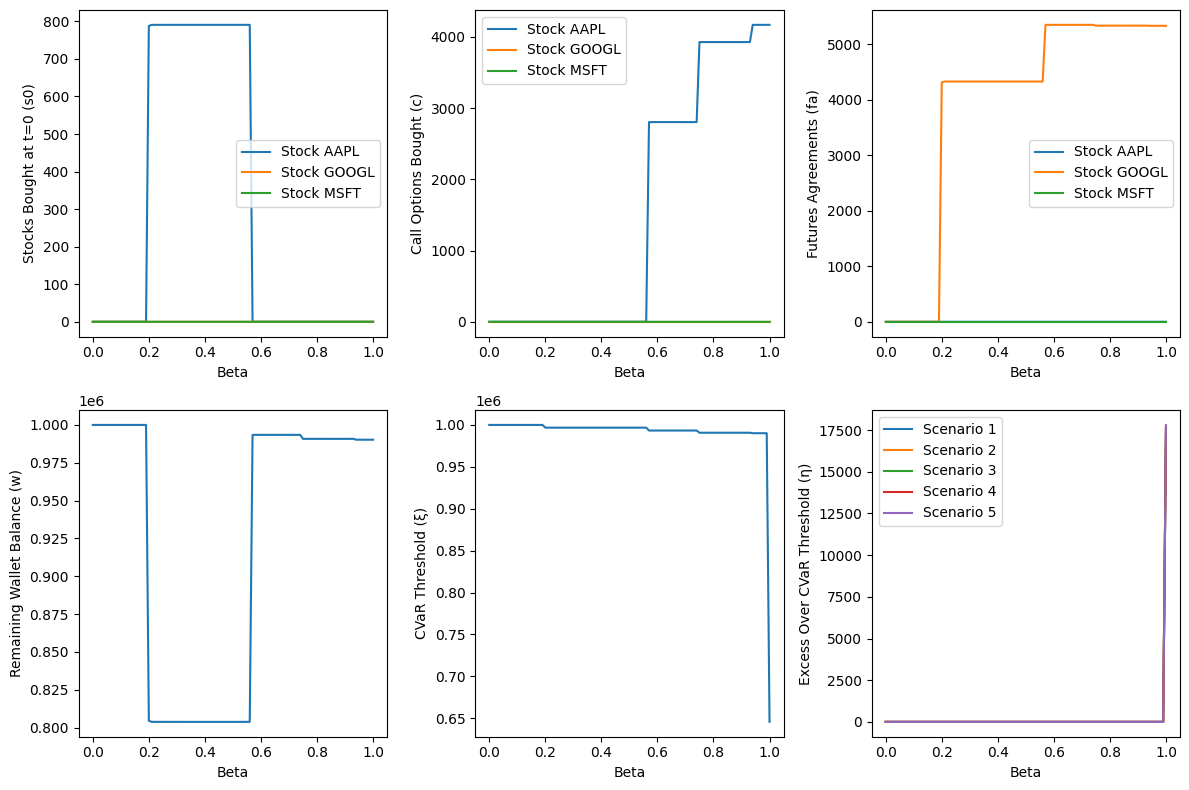

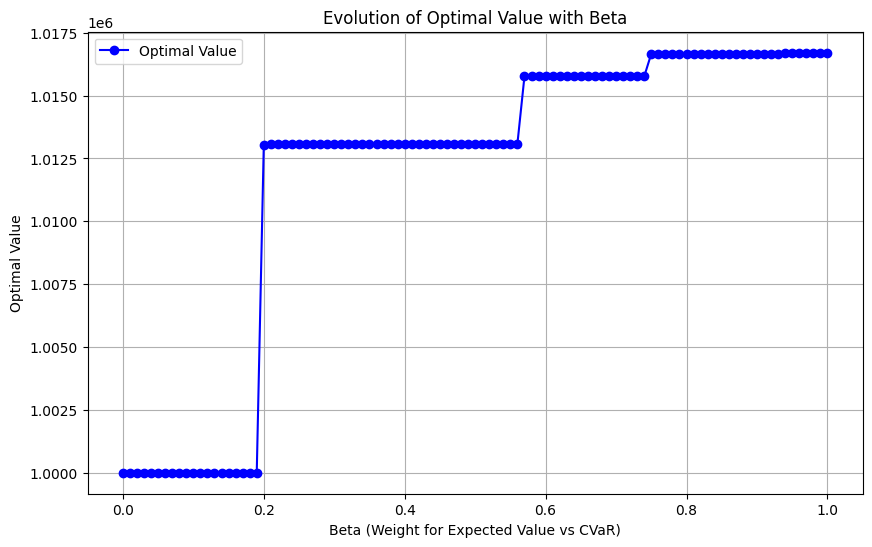

In [ ]:
beta_values = np.arange(0, 1.01, 0.01)

# Store results for plotting
s0_values = []
c_values = []
fa_values = []
w_values = []
ξ_values = []
η_values = []

optimal_values = []

for beta in beta_values:
    # Decision variables
    s0 = cp.Variable(N)#, integer=True)

    c = cp.Variable(N)#, integer=True)

    ci  = cp.Variable((N,M))#, integer=True)

    fa  = cp.Variable(N)#, integer=True)

    f0 = cp.Variable(N)#, integer=True)

    f1 = cp.Variable(N)#, integer=True)

    mj = cp.Variable((N,M))#,  integer=True)

    w = cp.Variable(nonneg=True)


    ni = cp.Variable(M, nonneg=True)

    xi = cp.Variable()


    # Objective function
    inner_sum = cp.sum(cp.multiply(p1, s0[:, None] + mj + ci), axis=0)
    expected_payoff = cp.sum(cp.multiply(prob, inner_sum))
    cvar_term = xi - (1 / (1 - alpha)) * cp.sum(cp.multiply(prob, ni))
    objective = cp.Maximize(beta * expected_payoff + (1 - beta) * cvar_term)

    # Constraints
    budget_constraint = (
        w + cp.sum(cp.multiply(pc, c)) + cp.sum(cp.multiply(f0, p0)) + cp.sum(cp.multiply(s0, p0)) == B
    )

    contract_constraints = [
        cp.sum(cp.multiply(psp, ci[:, i]) + cp.multiply(p1[:, i], mj[:, i])) <=
        w + cp.sum(cp.multiply(f0, pf)) + cp.sum(cp.multiply(f1, pf - p1[:, i]))
        for i in range(M)
    ]

    stock_allocation_constraints = [f0[j] + f1[j] == fa[j] for j in range(N)]

    futures_constraints = [
        f1[j] <= (w + cp.sum(cp.multiply(f0, pf))) / p1[j, i]
        for i in range(M) for j in range(N)
    ]

    executed_options_constraints = [
        ci[j, i] <= cp.multiply((p1[j, i] >= psp[j]), c[j]) for i in range(M) for j in range(N)
    ]

    cvar_constraints = [
       xi - cp.sum(cp.multiply(p1, s0[:, None] + mj + ci), axis=0) <=ni
    ]
    nneg_constraints = [
        s0 >= 0,           # Non-negative constraint for s0
        c >= 0,            # Non-negative constraint for c
        ci >= 0,           # Non-negative constraint for ci
        fa >= 0,           # Non-negative constraint for fa
        f0 >= 0,           # Non-negative constraint for f0
        f1 >= 0,           # Non-negative constraint for f1
        mj >= 0            # Non-negative constraint for mj
    ]

    constraints = (
        [budget_constraint] +
        contract_constraints +
        stock_allocation_constraints +
        futures_constraints +
        executed_options_constraints +
        cvar_constraints +
        nneg_constraints
    )

    # Solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    # Retrieve the optimal values of the variables
    s0_opt = s0.value
    mj_opt = mj.value
    ci_opt = ci.value

    # Compute the inner sum for each scenario
    inner_sum_values = np.sum(p1 * (s0_opt[:, None] + mj_opt + ci_opt), axis=0)

    # Compute the expected payoff
    expected_payoff_value = np.sum(prob * inner_sum_values)

    #print("Expected Payoff:", expected_payoff_value)

    # Stores the optimal value
    optimal_values.append(expected_payoff_value)

    # Store results
    s0_values.append(s0.value)
    c_values.append(c.value)
    fa_values.append(fa.value)
    w_values.append(w.value)
    ξ_values.append(xi.value)
    η_values.append(ni.value)

# Convert lists to arrays for plotting
s0_values = np.array(s0_values)
c_values = np.array(c_values).round(2)
fa_values = np.array(fa_values)
w_values = np.array(w_values)
ξ_values = np.array(ξ_values)
η_values = np.array(η_values)

# Plotting
plt.figure(figsize=(12, 8))

# Plot s0 (stocks bought at t=0)
plt.subplot(2, 3, 1)
for i in range(N):
    plt.plot(beta_values, s0_values[:, i], label=f"Stock {tickers[i]}")
plt.xlabel('Beta')
plt.ylabel('Stocks Bought at t=0 (s0)')
plt.legend()

# Plot c (call options bought)
plt.subplot(2, 3, 2)
for i in range(N):
    plt.plot(beta_values, c_values[:, i], label=f"Stock {tickers[i]}")
plt.xlabel('Beta')

plt.ylabel('Call Options Bought (c)')
plt.legend()

# Plot fa (futures agreements)
plt.subplot(2, 3, 3)
for i in range(N):
    plt.plot(beta_values, fa_values[:, i], label=f"Stock {tickers[i]}")
plt.xlabel('Beta')
plt.ylabel('Futures Agreements (fa)')
plt.legend()

# Plot w (remaining wallet balance)
plt.subplot(2, 3, 4)
plt.plot(beta_values, w_values)
plt.xlabel('Beta')
plt.ylabel('Remaining Wallet Balance (w)')

# Plot ξ (CVaR threshold)
plt.subplot(2, 3, 5)
plt.plot(beta_values, ξ_values)
plt.xlabel('Beta')
plt.ylabel('CVaR Threshold (ξ)')

# Plot η (excess over CVaR threshold)
plt.subplot(2, 3, 6)
for i in range(M):
    plt.plot(beta_values, η_values[:, i], label=f"Scenario {i+1}")
plt.xlabel('Beta')
plt.ylabel('Excess Over CVaR Threshold (η)')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(beta_values, optimal_values, marker='o', color='b', label="Optimal Value")
plt.title("Evolution of Optimal Value with Beta")
plt.xlabel("Beta (Weight for Expected Value vs CVaR)")
plt.ylabel("Optimal Value")
plt.grid(True)
plt.legend()
plt.show()


### EVPI e VSS for Real Values of Case 1 and 2
#### The output below concerns Case 2, for Case 1 we refer to the previous code block with the change of the value to integer.

In [ ]:
import numpy as np
import cvxpy as cp

# Settings from the second code (example: beta = 0.5)
beta = 0.5  # Set beta for risk-return tradeoff

# Parameters (Assume that you already have these defined)
tickers = ["AAPL", "GOOGL", "MSFT"]  # Replace with your tickers
p0 = np.array(get_current_prices(tickers))  # Current stock prices
prob = np.array([0.2, 0.2, 0.2, 0.2, 0.2])   # Scenario probabilities

# Simulated prices from second code
simulated_prices = monte_carlo_simulation(tickers, days=5, scenarios=5)  # (N x M matrix)
p1 = np.array(simulated_prices)  # Future prices (scenarios)
pc, psp = np.array(get_option_prices(tickers))  # Option prices, etc.
B = 1000000  # Budget
N = 3  # Number of assets
M = 5  # Number of scenarios
alpha = 0.95  # CVaR confidence level

# Futures data
futures_tickers = ["APC.F", "ABEC.F", "MSF.F"]  # Example futures tickers
futures_data = get_futures_prices(futures_tickers)

# Prices of futures
pf = np.array([item['last_price'] for item in futures_data])

# Initialize variables
s0 = cp.Variable(N)  # Stocks allocation
c = cp.Variable(N)  # Call options
ci = cp.Variable((N, M))  # Call options executed for each scenario
fa = cp.Variable(N)  # Futures allocation
f0 = cp.Variable(N)  # Futures at time 0
f1 = cp.Variable(N)  # Futures at time 1
mj = cp.Variable((N, M))  # Market values for each scenario
w = cp.Variable(nonneg=True)  # Total wealth

ni = cp.Variable(M, nonneg=True)  # CVaR-related variable
xi = cp.Variable()  # CVaR-related variable

# Objective function (Expected Payoff + CVaR term)
inner_sum = cp.sum(cp.multiply(p1, s0[:, None] + mj + ci), axis=0)
expected_payoff = cp.sum(cp.multiply(prob, inner_sum))  # Expected payoff
cvar_term = xi - (1 / (1 - alpha)) * cp.sum(cp.multiply(prob, ni))  # CVaR term
objective = cp.Maximize(beta * expected_payoff + (1 - beta) * cvar_term)  # Adjusted for beta

# Constraints
budget_constraint = (
    w + cp.sum(cp.multiply(pc, c)) + cp.sum(cp.multiply(f0, p0)) + cp.sum(cp.multiply(s0, p0)) == B
)

contract_constraints = [
    cp.sum(cp.multiply(psp, ci[:, i]) + cp.multiply(p1[:, i], mj[:, i])) <=
    w + cp.sum(cp.multiply(f0, pf)) + cp.sum(cp.multiply(f1, pf - p1[:, i]))
    for i in range(M)
]

stock_allocation_constraints = [f0[j] + f1[j] == fa[j] for j in range(N)]
futures_constraints = [
    f1[j] <= (w + cp.sum(cp.multiply(f0, pf))) / p1[j, i]
    for i in range(M) for j in range(N)
]
executed_options_constraints = [
    ci[j, i] <= cp.multiply((p1[j, i] >= psp[j]), c[j]) for i in range(M) for j in range(N)
]
cvar_constraints = [
   xi - cp.sum(cp.multiply(p1, s0[:, None] + mj + ci), axis=0) <= ni
]
nneg_constraints = [
    s0 >= 0, c >= 0, ci >= 0, fa >= 0, f0 >= 0, f1 >= 0, mj >= 0
]

# Combine all constraints
constraints = (
    [budget_constraint] +
    contract_constraints +
    stock_allocation_constraints +
    futures_constraints +
    executed_options_constraints +
    cvar_constraints +
    nneg_constraints
)

# Solve the problem in the base (stochastic) case
problem = cp.Problem(objective, constraints)
problem.solve()

# Get the optimal values
s0_opt = s0.value
mj_opt = mj.value
ci_opt = ci.value

# Compute the inner sum for each scenario
inner_sum_values = np.sum(p1 * (s0_opt[:, None] + mj_opt + ci_opt), axis=0)

# Compute the expected payoff for the stochastic case
expected_payoff_stochastic = np.sum(prob * inner_sum_values)

# Perfect Information: Solve for each individual scenario
perfect_info_values = []

for scenario_index in range(M):
    # Set the probability for the perfect information scenario to 1
    prob_perfect = np.zeros(M)
    prob_perfect[scenario_index] = 1

    # Re-solve the problem with perfect knowledge for this scenario
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Compute the expected payoff for the scenario
    inner_sum_values_perfect = np.sum(p1 * (s0.value[:, None] + mj.value + ci.value), axis=0)
    expected_payoff_perfect_info = np.sum(prob_perfect * inner_sum_values_perfect)
    perfect_info_values.append(expected_payoff_perfect_info)

# Calculate the EVPI
expected_value_perfect_information = np.mean(perfect_info_values)  # Average over all scenarios
evpi = expected_value_perfect_information - expected_payoff_stochastic

# Output the EVPI result
print(f"\n--- EVPI (Expected Value of Perfect Information) ---")
print(f"  Expected Payoff (Stochastic Case): {expected_payoff_stochastic:.2f}")
print(f"  Expected Payoff (Perfect Information): {expected_value_perfect_information:.2f}")
print(f"  EVPI: {evpi:.2f}")


Deterministic Value: 1011321.617331795
Perfect Information Value: 1021030.9369213857
Stochastic Value: 1011321.617331795
EVPI: 9709.319589590654
VSS: 0.0


## Case 3 - Artificial Data

In [ ]:
tickers = ["AAPL", "GOOGL", "MSFT"]

# Make parameters pretty and distinguish modified ones
p0_, p1_, pc_, psp_, fp_, B_, N_, M_, alpha_, prob_ = pretty_params(rf=0.04, mu=0, volly=0.28)
prob_ = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
# Use the modified parameters directly in computations
retav_ = np.mean(p1_, axis=1)

# Display both original and modified parameters if needed
print(f"\n Modified initial prices: {p0_}")
print(f"\n Modified next period prices (mean): {retav_}")
print(f"\n Modified call price: {pc_}")
print(f"\n Modified strike price: {psp_}")
print(f"\n Modified future price: {fp_}")



 Modified initial prices: [248.1300048828125, 189.82000732421875, 447.2699890136719]

 Modified next period prices (mean): [288.43877098 225.01596675 466.26404286]

 Modified call price: [ 4.15 12.12 10.62]

 Modified strike price: [330 240 595]

 Modified future price: [258.05520508 197.41280762 465.16078857]


### Analysis across multiple Beta values with artificial data.

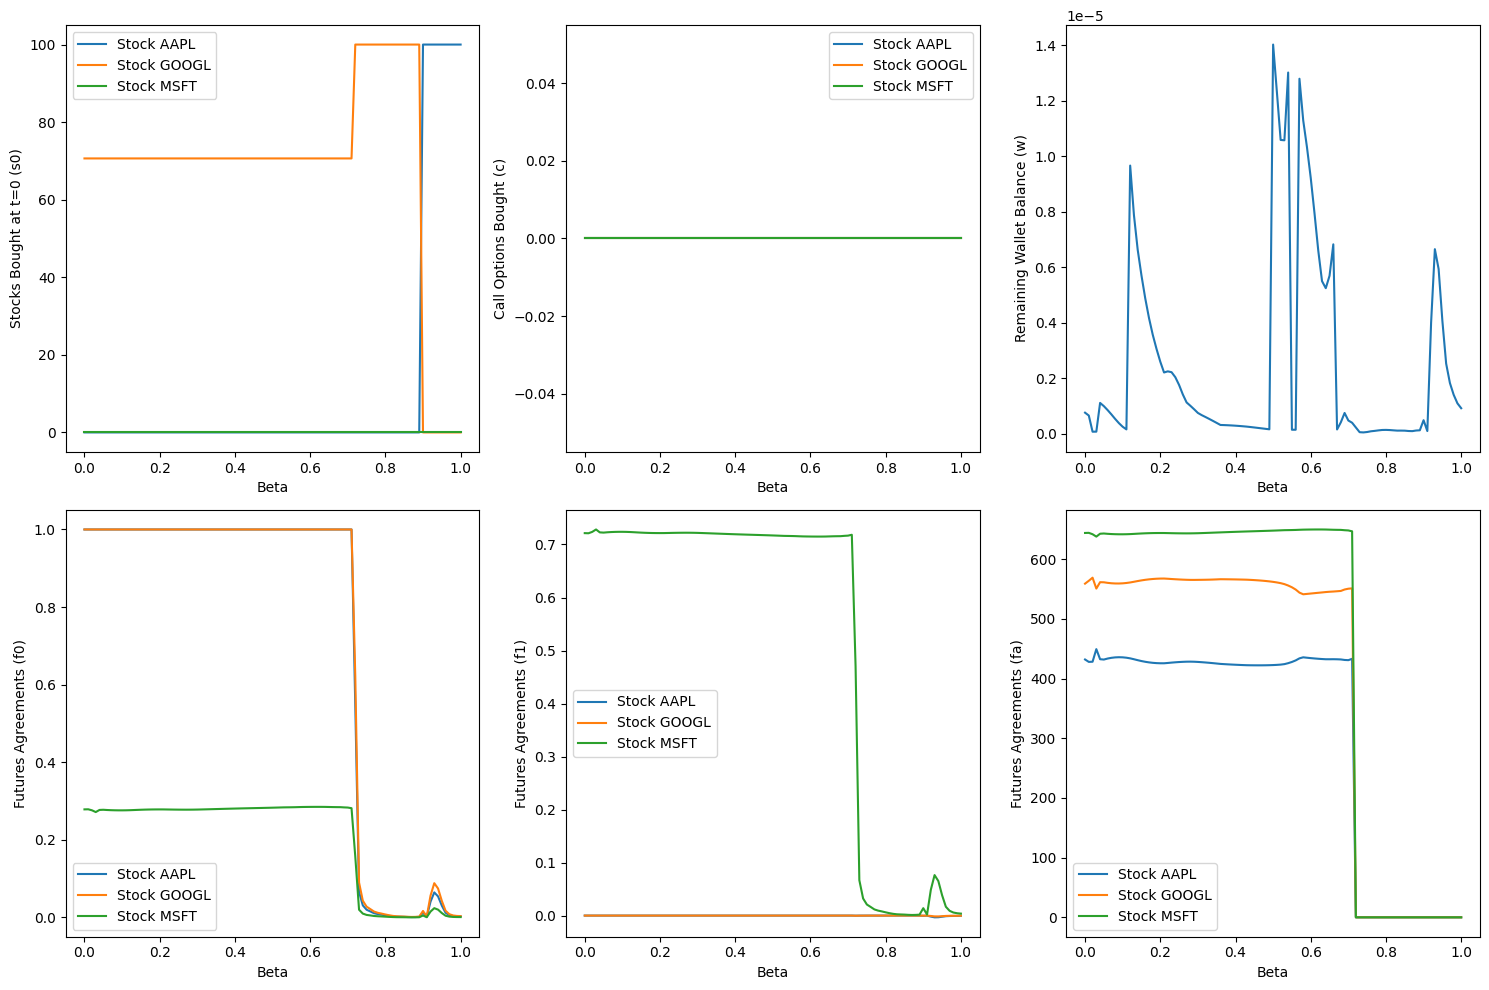

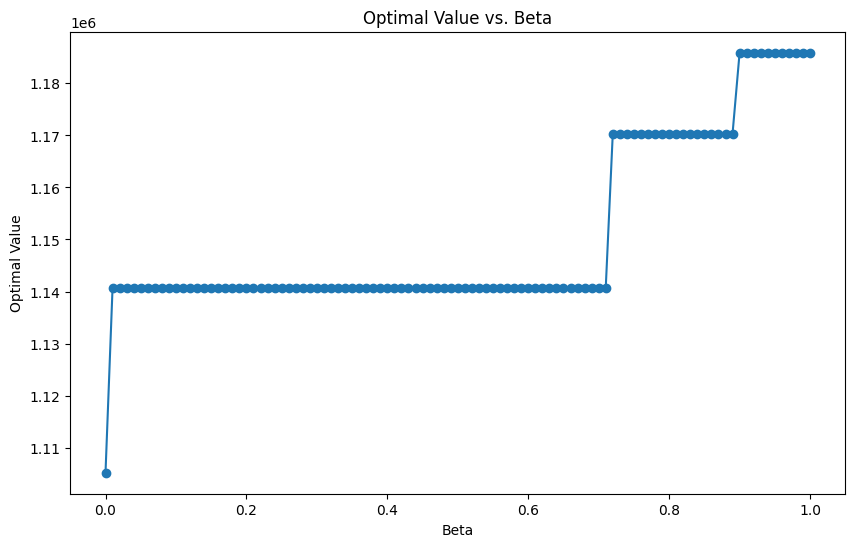

In [ ]:
# Ensure the rest of the code uses modified variables where appropriate
beta_values = np.arange(0, 1.01, 0.01)

# Store results for plotting
s0_values = []
f0_values = []
f1_values = []
c_values = []
fa_values = []
w_values = []
ξ_values = []
η_values = []
optimal_values = []

# Iteration over beta
for beta in beta_values:
    # Decision variables
    s0 = cp.Variable(N_)  # Stocks at t=0
    c = cp.Variable(N_)  # Call options
    ci = cp.Variable((N_, M_))  # Call options executed
    fa = cp.Variable(N_)  # Futures agreements
    f0 = cp.Variable(N_)  # Futures at t=0
    f1 = cp.Variable(N_)  # Futures at t=1
    mj = cp.Variable((N_, M_))  # Adjustments
    w = cp.Variable(nonneg=True)  # Wallet balance
    ni = cp.Variable(M_, nonneg=True)  # CVaR excess
    xi = cp.Variable()  # CVaR threshold

    # Objective function
    inner_sum = cp.sum(cp.multiply(p1_, s0[:, None] + mj + ci), axis=0)
    expected_payoff = cp.sum(cp.multiply(prob_, inner_sum))
    cvar_term = xi - (1 / (1 - alpha_)) * cp.sum(cp.multiply(prob_, ni))
    objective = cp.Maximize(beta * expected_payoff + (1 - beta) * cvar_term)

    # Constraints
    budget_constraint = (
        w + cp.sum(cp.multiply(pc_, c)) + cp.sum(cp.multiply(f0, p0_)) + cp.sum(cp.multiply(s0, p0_)) == B_
    )

    contract_constraints = [
        cp.sum(cp.multiply(psp_, ci[:, i]) + cp.multiply(p1_[:, i], mj[:, i])) <=
        w + cp.sum(cp.multiply(f0, fp_)) + cp.sum(cp.multiply(f1, fp_ - p1_[:, i]))
        for i in range(M_)
    ]

    stock_allocation_constraints = [f0[j] + f1[j] == fa[j] for j in range(N_)]

    futures_constraints = [
        f1[j] <= (w + cp.sum(cp.multiply(f0, fp_))) / p1_[j, i]
        for i in range(M_) for j in range(N_)
    ]

    executed_options_constraints = [
        ci[j, i] <= cp.multiply((p1_[j, i] >= psp_[j]), c[j]) for i in range(M_) for j in range(N_)
    ]

    cvar_constraints = [
       xi - cp.sum(cp.multiply(p1_, s0[:, None] + mj + ci), axis=0) <= ni
    ]

    nneg_constraints = [
        s0 >= 0, c >= 0, ci >= 0, fa >= 0, f0 >= 0, f1 >= 0, mj >= 0
    ]

    constraints = (
        [budget_constraint] +
        contract_constraints +
        stock_allocation_constraints +
        futures_constraints +
        executed_options_constraints +
        cvar_constraints +
        nneg_constraints
    )

    # Solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Retrieve optimal values and compute expected payoff
    s0_opt = s0.value
    mj_opt = mj.value
    ci_opt = ci.value
    inner_sum_values = np.sum(p1_ * (s0_opt[:, None] + mj_opt + ci_opt), axis=0)
    expected_payoff_value = np.sum(prob_ * inner_sum_values)

    # Store results
    optimal_values.append(expected_payoff_value)
    s0_values.append(s0.value)
    c_values.append(c.value)
    fa_values.append(fa.value)
    w_values.append(w.value)
    ξ_values.append(xi.value)
    η_values.append(ni.value)
    f0_values.append(f0.value)
    f1_values.append(f1.value)

# Convert lists to arrays for plotting
s0_values = np.array(s0_values)
c_values = np.array(c_values).round(2)
fa_values = np.array(fa_values)
w_values = np.array(w_values)
ξ_values = np.array(ξ_values)
η_values = np.array(η_values)
f0_values = np.array(f0_values)
f1_values = np.array(f1_values)

# Plot the other variables
plt.figure(figsize=(15, 10))

# Plot s0 (stocks bought at t=0)
plt.subplot(2, 3, 1)
for i in range(N_):
    plt.plot(beta_values, s0_values[:, i] * p0_[i] * 100 / B_, label=f"Stock {tickers[i]}")
plt.xlabel('Beta')
plt.ylabel('Stocks Bought at t=0 (s0)')
plt.legend()

# Plot c (call options bought)
plt.subplot(2, 3, 2)
for i in range(N_):
    plt.plot(beta_values, c_values[:, i] * pc_[i] * 100 / B_, label=f"Stock {tickers[i]}")
plt.xlabel('Beta')
plt.ylabel('Call Options Bought (c)')
plt.legend()

# Plot f0 (futures agreements at t=0)
plt.subplot(2, 3, 4)
for i in range(N_):
    plt.plot(beta_values, f0_values[:, i] / (fa_values[:, i] + 0.01), label=f"Stock {tickers[i]}")
plt.xlabel('Beta')
plt.ylabel('Futures Agreements (f0)')
plt.legend()

# Plot f1 (futures agreements at t=1)
plt.subplot(2, 3, 5)
for i in range(N_):
    plt.plot(beta_values, f1_values[:, i] / (fa_values[:, i] + 0.01), label=f"Stock {tickers[i]}")
plt.xlabel('Beta')
plt.ylabel('Futures Agreements (f1)')
plt.legend()

# Plot fa (futures agreements total)
plt.subplot(2, 3, 6)
for i in range(N_):
    plt.plot(beta_values, fa_values[:, i], label=f"Stock {tickers[i]}")
plt.xlabel('Beta')
plt.ylabel('Futures Agreements (fa)')
plt.legend()

# Plot w (remaining wallet balance)
plt.subplot(2, 3, 3)
plt.plot(beta_values, w_values * 100 / B_)
plt.xlabel('Beta')
plt.ylabel('Remaining Wallet Balance (w)')

plt.tight_layout()  # Adjust layout for better appearance
plt.show()

# Plot Optimal Value Evolution with Beta
plt.figure(figsize=(10, 6))
plt.plot(beta_values, optimal_values, marker='o')
plt.xlabel('Beta')
plt.ylabel('Optimal Value')
plt.title('Optimal Value vs. Beta')
plt.show()


### EVPI e VSS artificial data of case 3

In [ ]:
# Get modified parameters
p0_, p1_, pc_, psp_, fp_, B_, N_, M_, alpha_, prob_ = pretty_params(rf=0.04, mu=0, volly=0.28)
prob_ = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
# Print modified parameters for clarity
retav_ = np.mean(p1_, axis=1)
print(f"\nModified initial prices: {p0_}")
print(f"\nModified next period prices (mean): {retav_}")
print(f"\nModified call price: {pc_}")
print(f"\nModified strike price: {psp_}")
print(f"\nModified future price: {fp_}")

# Initialize variables for the optimization problem
s0 = cp.Variable(N_)  # Stocks allocation
c = cp.Variable(N_)  # Call options
ci = cp.Variable((N_, M_))  # Call options executed for each scenario
fa = cp.Variable(N_)  # Futures allocation
f0 = cp.Variable(N_)  # Futures at time 0
f1 = cp.Variable(N_)  # Futures at time 1
mj = cp.Variable((N_, M_))  # Market values for each scenario
w = cp.Variable(nonneg=True)  # Total wealth

ni = cp.Variable(M_, nonneg=True)  # CVaR-related variable
xi = cp.Variable()  # CVaR-related variable

# Objective function (Expected Payoff + CVaR term)
inner_sum = cp.sum(cp.multiply(p1_, s0[:, None] + mj + ci), axis=0)
expected_payoff = cp.sum(cp.multiply(prob_, inner_sum))  # Expected payoff
cvar_term = xi - (1 / (1 - alpha_)) * cp.sum(cp.multiply(prob_, ni))  # CVaR term
objective = cp.Maximize(beta * expected_payoff + (1 - beta) * cvar_term)  # Adjusted for beta

# Constraints
budget_constraint = (
    w + cp.sum(cp.multiply(pc_, c)) + cp.sum(cp.multiply(f0, p0_)) + cp.sum(cp.multiply(s0, p0_)) == B_
)

contract_constraints = [
    cp.sum(cp.multiply(psp_, ci[:, i]) + cp.multiply(p1_[:, i], mj[:, i])) <=
    w + cp.sum(cp.multiply(f0, fp_)) + cp.sum(cp.multiply(f1, fp_ - p1_[:, i]))
    for i in range(M_)
]

stock_allocation_constraints = [f0[j] + f1[j] == fa[j] for j in range(N_)]
futures_constraints = [
    f1[j] <= (w + cp.sum(cp.multiply(f0, fp_))) / p1_[j, i]
    for i in range(M_) for j in range(N_)
]
executed_options_constraints = [
    ci[j, i] <= cp.multiply((p1_[j, i] >= psp_[j]), c[j]) for i in range(M_) for j in range(N_)
]
cvar_constraints = [
   xi - cp.sum(cp.multiply(p1_, s0[:, None] + mj + ci), axis=0) <= ni
]
nneg_constraints = [
    s0 >= 0, c >= 0, ci >= 0, fa >= 0, f0 >= 0, f1 >= 0, mj >= 0
]

# Combine all constraints
constraints = (
    [budget_constraint] +
    contract_constraints +
    stock_allocation_constraints +
    futures_constraints +
    executed_options_constraints +
    cvar_constraints +
    nneg_constraints
)

# Solve the problem in the base (stochastic) case
problem = cp.Problem(objective, constraints)
problem.solve()

# Get the optimal values
s0_opt = s0.value
mj_opt = mj.value
ci_opt = ci.value

# Compute the inner sum for each scenario
inner_sum_values = np.sum(p1_ * (s0_opt[:, None] + mj_opt + ci_opt), axis=0)

# Compute the expected payoff for the stochastic case
expected_payoff_stochastic = np.sum(prob_ * inner_sum_values)

# Perfect Information: Solve for each individual scenario
perfect_info_values = []

for scenario_index in range(M_):
    # Set the probability for the perfect information scenario to 1
    prob_perfect = np.zeros(M_)
    prob_perfect[scenario_index] = 1

    # Re-solve the problem with perfect knowledge for this scenario
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Compute the expected payoff for the scenario
    inner_sum_values_perfect = np.sum(p1_ * (s0.value[:, None] + mj.value + ci.value), axis=0)
    expected_payoff_perfect_info = np.sum(prob_perfect * inner_sum_values_perfect)
    perfect_info_values.append(expected_payoff_perfect_info)

# Calculate the EVPI
expected_value_perfect_information = np.mean(perfect_info_values)  # Average over all scenarios
evpi = expected_value_perfect_information - expected_payoff_stochastic

# Output the EVPI result
print(f"\n--- EVPI (Expected Value of Perfect Information) ---")
print(f"  Expected Payoff (Stochastic Case): {expected_payoff_stochastic:.2f}")
print(f"  Expected Payoff (Perfect Information): {expected_value_perfect_information:.2f}")
print(f"  EVPI: {evpi:.2f}")

Deterministic Value: 1185417.4676194515
Perfect Information Value: 1247140.6525178326
Stochastic Value: 1185882.4998122542
EVPI: 61258.152705578366
VSS: 465.03219280275516


##**Different Probabilities**
## Case 4 - Real Data

### Analysis across multiple Beta values with real data.

In [ ]:
prob = np.array([0.05, 0.25, 0.4, 0.25, 0.05])

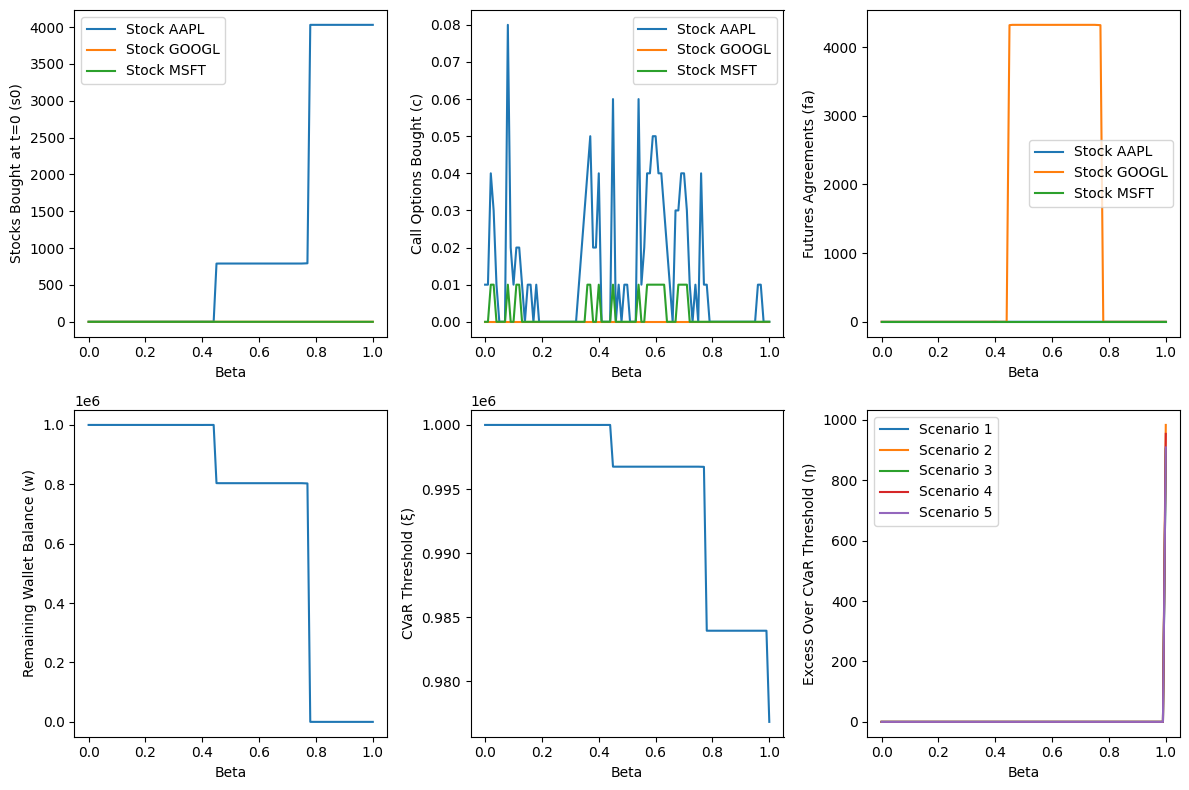

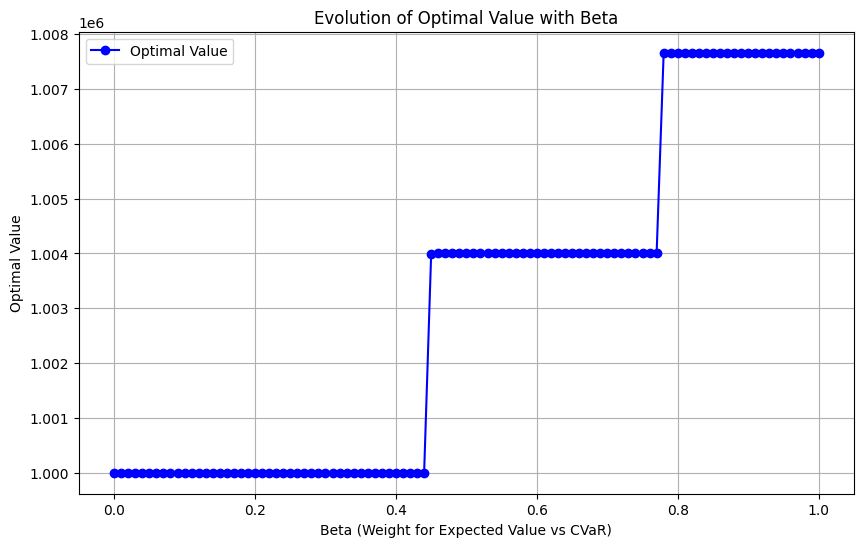

In [ ]:
beta_values = np.arange(0, 1.01, 0.01)

# Store results for plotting
s0_values = []
c_values = []
fa_values = []
w_values = []
ξ_values = []
η_values = []

optimal_values = []

for beta in beta_values:
    # Decision variables
    s0 = cp.Variable(N)#, integer=True)

    c = cp.Variable(N)#, integer=True)

    ci  = cp.Variable((N,M))#, integer=True)

    fa  = cp.Variable(N)#, integer=True)

    f0 = cp.Variable(N)#, integer=True)

    f1 = cp.Variable(N)#, integer=True)

    mj = cp.Variable((N,M))#,  integer=True)

    w = cp.Variable(nonneg=True)


    ni = cp.Variable(M, nonneg=True)

    xi = cp.Variable()


    # Objective function
    inner_sum = cp.sum(cp.multiply(p1, s0[:, None] + mj + ci), axis=0)
    expected_payoff = cp.sum(cp.multiply(prob, inner_sum))
    cvar_term = xi - (1 / (1 - alpha)) * cp.sum(cp.multiply(prob, ni))
    objective = cp.Maximize(beta * expected_payoff + (1 - beta) * cvar_term)

    # Constraints
    budget_constraint = (
        w + cp.sum(cp.multiply(pc, c)) + cp.sum(cp.multiply(f0, p0)) + cp.sum(cp.multiply(s0, p0)) == B
    )

    contract_constraints = [
        cp.sum(cp.multiply(psp, ci[:, i]) + cp.multiply(p1[:, i], mj[:, i])) <=
        w + cp.sum(cp.multiply(f0, pf)) + cp.sum(cp.multiply(f1, pf - p1[:, i]))
        for i in range(M)
    ]

    stock_allocation_constraints = [f0[j] + f1[j] == fa[j] for j in range(N)]

    futures_constraints = [
        f1[j] <= (w + cp.sum(cp.multiply(f0, pf))) / p1[j, i]
        for i in range(M) for j in range(N)
    ]

    executed_options_constraints = [
        ci[j, i] <= cp.multiply((p1[j, i] >= psp[j]), c[j]) for i in range(M) for j in range(N)
    ]

    cvar_constraints = [
       xi - cp.sum(cp.multiply(p1, s0[:, None] + mj + ci), axis=0) <=ni
    ]
    nneg_constraints = [
        s0 >= 0,           # Non-negative constraint for s0
        c >= 0,            # Non-negative constraint for c
        ci >= 0,           # Non-negative constraint for ci
        fa >= 0,           # Non-negative constraint for fa
        f0 >= 0,           # Non-negative constraint for f0
        f1 >= 0,           # Non-negative constraint for f1
        mj >= 0            # Non-negative constraint for mj
    ]

    constraints = (
        [budget_constraint] +
        contract_constraints +
        stock_allocation_constraints +
        futures_constraints +
        executed_options_constraints +
        cvar_constraints +
        nneg_constraints
    )

    # Solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    # Retrieve the optimal values of the variables
    s0_opt = s0.value
    mj_opt = mj.value
    ci_opt = ci.value

    # Compute the inner sum for each scenario
    inner_sum_values = np.sum(p1 * (s0_opt[:, None] + mj_opt + ci_opt), axis=0)

    # Compute the expected payoff
    expected_payoff_value = np.sum(prob * inner_sum_values)

    #print("Expected Payoff:", expected_payoff_value)

    # Memorizza il valore ottimale
    optimal_values.append(expected_payoff_value)

    # Store results
    s0_values.append(s0.value)
    c_values.append(c.value)
    fa_values.append(fa.value)
    w_values.append(w.value)
    ξ_values.append(xi.value)
    η_values.append(ni.value)

# Convert lists to arrays for plotting
s0_values = np.array(s0_values)
c_values = np.array(c_values).round(2)
fa_values = np.array(fa_values)
w_values = np.array(w_values)
ξ_values = np.array(ξ_values)
η_values = np.array(η_values)

# Plotting
plt.figure(figsize=(12, 8))

# Plot s0 (stocks bought at t=0)
plt.subplot(2, 3, 1)
for i in range(N):
    plt.plot(beta_values, s0_values[:, i], label=f"Stock {tickers[i]}")
plt.xlabel('Beta')
plt.ylabel('Stocks Bought at t=0 (s0)')
plt.legend()

# Plot c (call options bought)
plt.subplot(2, 3, 2)
for i in range(N):
    plt.plot(beta_values, c_values[:, i], label=f"Stock {tickers[i]}")
plt.xlabel('Beta')

plt.ylabel('Call Options Bought (c)')
plt.legend()

# Plot fa (futures agreements)
plt.subplot(2, 3, 3)
for i in range(N):
    plt.plot(beta_values, fa_values[:, i], label=f"Stock {tickers[i]}")
plt.xlabel('Beta')
plt.ylabel('Futures Agreements (fa)')
plt.legend()

# Plot w (remaining wallet balance)
plt.subplot(2, 3, 4)
plt.plot(beta_values, w_values)
plt.xlabel('Beta')
plt.ylabel('Remaining Wallet Balance (w)')

# Plot ξ (CVaR threshold)
plt.subplot(2, 3, 5)
plt.plot(beta_values, ξ_values)
plt.xlabel('Beta')
plt.ylabel('CVaR Threshold (ξ)')

# Plot η (excess over CVaR threshold)
plt.subplot(2, 3, 6)
for i in range(M):
    plt.plot(beta_values, η_values[:, i], label=f"Scenario {i+1}")
plt.xlabel('Beta')
plt.ylabel('Excess Over CVaR Threshold (η)')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(beta_values, optimal_values, marker='o', color='b', label="Optimal Value")
plt.title("Evolution of Optimal Value with Beta")
plt.xlabel("Beta (Weight for Expected Value vs CVaR)")
plt.ylabel("Optimal Value")
plt.grid(True)
plt.legend()
plt.show()

### EVPI e VSS for real data of Case 4

In [ ]:
import numpy as np
import cvxpy as cp

# Settings from the second code (example: beta = 0.5)
beta = 0.5  # Set beta for risk-return tradeoff

# Parameters (Assume that you already have these defined)
tickers = ["AAPL", "GOOGL", "MSFT"]  # Replace with your tickers
p0 = np.array(get_current_prices(tickers))  # Current stock prices
prob = np.array([0.05, 0.25, 0.4, 0.25, 0.05])   # Scenario probabilities

# Simulated prices from second code
simulated_prices = monte_carlo_simulation(tickers, days=5, scenarios=5)  # (N x M matrix)
p1 = np.array(simulated_prices)  # Future prices (scenarios)
pc, psp = np.array(get_option_prices(tickers))  # Option prices, etc.
B = 1000000  # Budget
N = 3  # Number of assets
M = 5  # Number of scenarios
alpha = 0.95  # CVaR confidence level

# Futures data
futures_tickers = ["APC.F", "ABEC.F", "MSF.F"]  # Example futures tickers
futures_data = get_futures_prices(futures_tickers)

# Prices of futures
pf = np.array([item['last_price'] for item in futures_data])

# Initialize variables
s0 = cp.Variable(N)  # Stocks allocation
c = cp.Variable(N)  # Call options
ci = cp.Variable((N, M))  # Call options executed for each scenario
fa = cp.Variable(N)  # Futures allocation
f0 = cp.Variable(N)  # Futures at time 0
f1 = cp.Variable(N)  # Futures at time 1
mj = cp.Variable((N, M))  # Market values for each scenario
w = cp.Variable(nonneg=True)  # Total wealth

ni = cp.Variable(M, nonneg=True)  # CVaR-related variable
xi = cp.Variable()  # CVaR-related variable

# Objective function (Expected Payoff + CVaR term)
inner_sum = cp.sum(cp.multiply(p1, s0[:, None] + mj + ci), axis=0)
expected_payoff = cp.sum(cp.multiply(prob, inner_sum))  # Expected payoff
cvar_term = xi - (1 / (1 - alpha)) * cp.sum(cp.multiply(prob, ni))  # CVaR term
objective = cp.Maximize(beta * expected_payoff + (1 - beta) * cvar_term)  # Adjusted for beta

# Constraints
budget_constraint = (
    w + cp.sum(cp.multiply(pc, c)) + cp.sum(cp.multiply(f0, p0)) + cp.sum(cp.multiply(s0, p0)) == B
)

contract_constraints = [
    cp.sum(cp.multiply(psp, ci[:, i]) + cp.multiply(p1[:, i], mj[:, i])) <=
    w + cp.sum(cp.multiply(f0, pf)) + cp.sum(cp.multiply(f1, pf - p1[:, i]))
    for i in range(M)
]

stock_allocation_constraints = [f0[j] + f1[j] == fa[j] for j in range(N)]
futures_constraints = [
    f1[j] <= (w + cp.sum(cp.multiply(f0, pf))) / p1[j, i]
    for i in range(M) for j in range(N)
]
executed_options_constraints = [
    ci[j, i] <= cp.multiply((p1[j, i] >= psp[j]), c[j]) for i in range(M) for j in range(N)
]
cvar_constraints = [
   xi - cp.sum(cp.multiply(p1, s0[:, None] + mj + ci), axis=0) <= ni
]
nneg_constraints = [
    s0 >= 0, c >= 0, ci >= 0, fa >= 0, f0 >= 0, f1 >= 0, mj >= 0
]

# Combine all constraints
constraints = (
    [budget_constraint] +
    contract_constraints +
    stock_allocation_constraints +
    futures_constraints +
    executed_options_constraints +
    cvar_constraints +
    nneg_constraints
)

# Solve the problem in the base (stochastic) case
problem = cp.Problem(objective, constraints)
problem.solve()

# Get the optimal values
s0_opt = s0.value
mj_opt = mj.value
ci_opt = ci.value

# Compute the inner sum for each scenario
inner_sum_values = np.sum(p1 * (s0_opt[:, None] + mj_opt + ci_opt), axis=0)

# Compute the expected payoff for the stochastic case
expected_payoff_stochastic = np.sum(prob * inner_sum_values)

# Perfect Information: Solve for each individual scenario
perfect_info_values = []

for scenario_index in range(M):
    # Set the probability for the perfect information scenario to 1
    prob_perfect = np.zeros(M)
    prob_perfect[scenario_index] = 1

    # Re-solve the problem with perfect knowledge for this scenario
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Compute the expected payoff for the scenario
    inner_sum_values_perfect = np.sum(p1 * (s0.value[:, None] + mj.value + ci.value), axis=0)
    expected_payoff_perfect_info = np.sum(prob_perfect * inner_sum_values_perfect)
    perfect_info_values.append(expected_payoff_perfect_info)

# Calculate the EVPI
expected_value_perfect_information = np.mean(perfect_info_values)  # Average over all scenarios
evpi = expected_value_perfect_information - expected_payoff_stochastic

# Output the EVPI result
print(f"\n--- EVPI (Expected Value of Perfect Information) ---")
print(f"  Expected Payoff (Stochastic Case): {expected_payoff_stochastic:.2f}")
print(f"  Expected Payoff (Perfect Information): {expected_value_perfect_information:.2f}")
print(f"  EVPI: {evpi:.2f}")


Deterministic Value: 1011321.617331795
Perfect Information Value: 1010962.8189953669
Stochastic Value: 1007663.0150913766
EVPI: 3299.8039039903088
VSS: -3658.602240418433


## Case 5 - Artificial Data

### Analysis across multiple Beta values with artificial data

In [ ]:
prob_ = np.array([0.05, 0.25, 0.4, 0.25, 0.05])

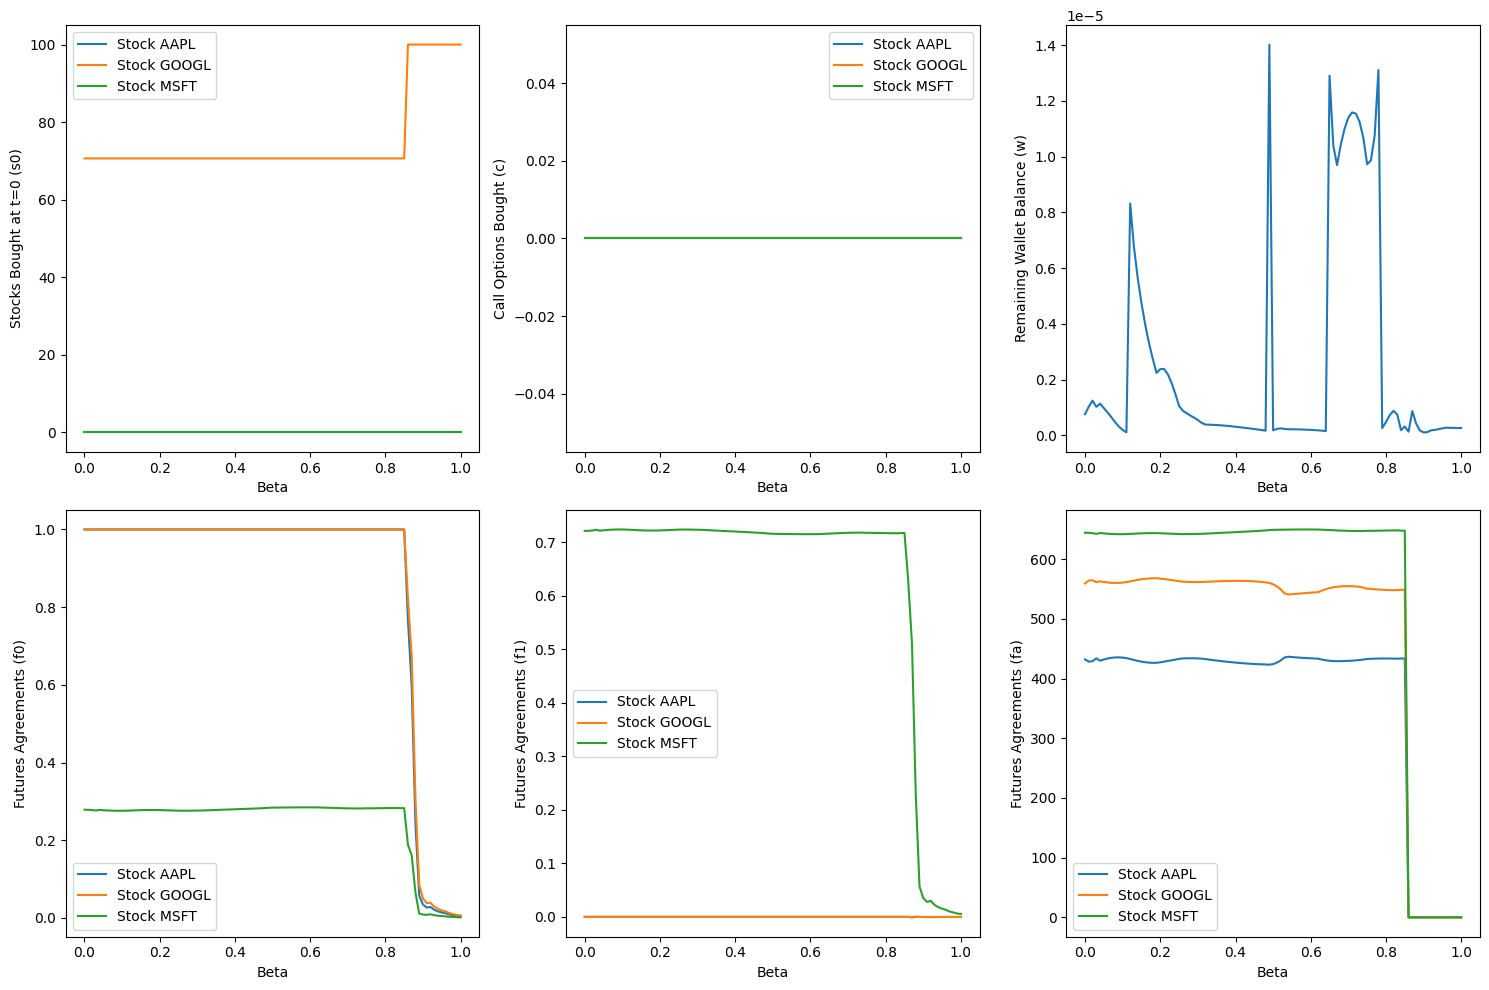

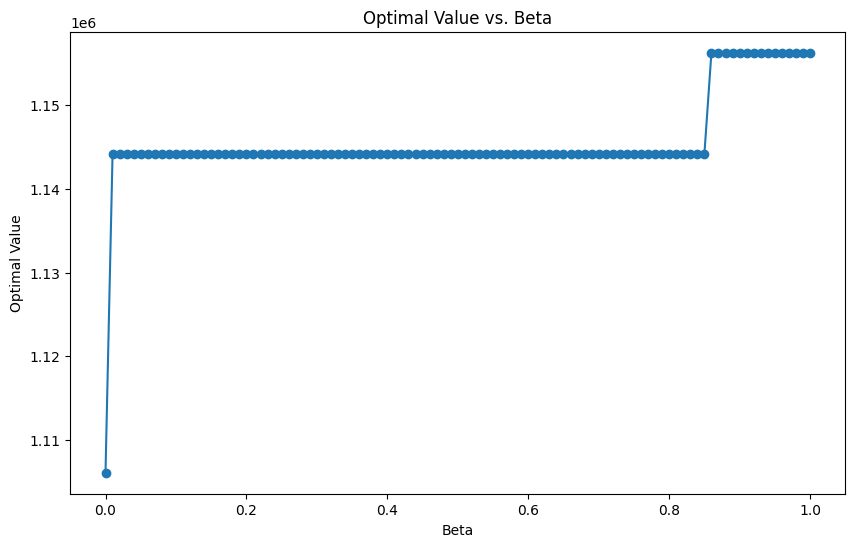

In [ ]:
# Ensure the rest of the code uses modified variables where appropriate
beta_values = np.arange(0, 1.01, 0.01)

# Store results for plotting
s0_values = []
f0_values = []
f1_values = []
c_values = []
fa_values = []
w_values = []
ξ_values = []
η_values = []
optimal_values = []

# Iteration over beta
for beta in beta_values:
    # Decision variables
    s0 = cp.Variable(N_)  # Stocks at t=0
    c = cp.Variable(N_)  # Call options
    ci = cp.Variable((N_, M_))  # Call options executed
    fa = cp.Variable(N_)  # Futures agreements
    f0 = cp.Variable(N_)  # Futures at t=0
    f1 = cp.Variable(N_)  # Futures at t=1
    mj = cp.Variable((N_, M_))  # Adjustments
    w = cp.Variable(nonneg=True)  # Wallet balance
    ni = cp.Variable(M_, nonneg=True)  # CVaR excess
    xi = cp.Variable()  # CVaR threshold

    # Objective function
    inner_sum = cp.sum(cp.multiply(p1_, s0[:, None] + mj + ci), axis=0)
    expected_payoff = cp.sum(cp.multiply(prob_, inner_sum))
    cvar_term = xi - (1 / (1 - alpha_)) * cp.sum(cp.multiply(prob_, ni))
    objective = cp.Maximize(beta * expected_payoff + (1 - beta) * cvar_term)

    # Constraints
    budget_constraint = (
        w + cp.sum(cp.multiply(pc_, c)) + cp.sum(cp.multiply(f0, p0_)) + cp.sum(cp.multiply(s0, p0_)) == B_
    )

    contract_constraints = [
        cp.sum(cp.multiply(psp_, ci[:, i]) + cp.multiply(p1_[:, i], mj[:, i])) <=
        w + cp.sum(cp.multiply(f0, fp_)) + cp.sum(cp.multiply(f1, fp_ - p1_[:, i]))
        for i in range(M_)
    ]

    stock_allocation_constraints = [f0[j] + f1[j] == fa[j] for j in range(N_)]

    futures_constraints = [
        f1[j] <= (w + cp.sum(cp.multiply(f0, fp_))) / p1_[j, i]
        for i in range(M_) for j in range(N_)
    ]

    executed_options_constraints = [
        ci[j, i] <= cp.multiply((p1_[j, i] >= psp_[j]), c[j]) for i in range(M_) for j in range(N_)
    ]

    cvar_constraints = [
       xi - cp.sum(cp.multiply(p1_, s0[:, None] + mj + ci), axis=0) <= ni
    ]

    nneg_constraints = [
        s0 >= 0, c >= 0, ci >= 0, fa >= 0, f0 >= 0, f1 >= 0, mj >= 0
    ]

    constraints = (
        [budget_constraint] +
        contract_constraints +
        stock_allocation_constraints +
        futures_constraints +
        executed_options_constraints +
        cvar_constraints +
        nneg_constraints
    )

    # Solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Retrieve optimal values and compute expected payoff
    s0_opt = s0.value
    mj_opt = mj.value
    ci_opt = ci.value
    inner_sum_values = np.sum(p1_ * (s0_opt[:, None] + mj_opt + ci_opt), axis=0)
    expected_payoff_value = np.sum(prob_ * inner_sum_values)

    # Store results
    optimal_values.append(expected_payoff_value)
    s0_values.append(s0.value)
    c_values.append(c.value)
    fa_values.append(fa.value)
    w_values.append(w.value)
    ξ_values.append(xi.value)
    η_values.append(ni.value)
    f0_values.append(f0.value)
    f1_values.append(f1.value)

# Convert lists to arrays for plotting
s0_values = np.array(s0_values)
c_values = np.array(c_values).round(2)
fa_values = np.array(fa_values)
w_values = np.array(w_values)
ξ_values = np.array(ξ_values)
η_values = np.array(η_values)
f0_values = np.array(f0_values)
f1_values = np.array(f1_values)

# Plot the other variables
plt.figure(figsize=(15, 10))

# Plot s0 (stocks bought at t=0)
plt.subplot(2, 3, 1)
for i in range(N_):
    plt.plot(beta_values, s0_values[:, i] * p0_[i] * 100 / B_, label=f"Stock {tickers[i]}")
plt.xlabel('Beta')
plt.ylabel('Stocks Bought at t=0 (s0)')
plt.legend()

# Plot c (call options bought)
plt.subplot(2, 3, 2)
for i in range(N_):
    plt.plot(beta_values, c_values[:, i] * pc_[i] * 100 / B_, label=f"Stock {tickers[i]}")
plt.xlabel('Beta')
plt.ylabel('Call Options Bought (c)')
plt.legend()

# Plot f0 (futures agreements at t=0)
plt.subplot(2, 3, 4)
for i in range(N_):
    plt.plot(beta_values, f0_values[:, i] / (fa_values[:, i] + 0.01), label=f"Stock {tickers[i]}")
plt.xlabel('Beta')
plt.ylabel('Futures Agreements (f0)')
plt.legend()

# Plot f1 (futures agreements at t=1)
plt.subplot(2, 3, 5)
for i in range(N_):
    plt.plot(beta_values, f1_values[:, i] / (fa_values[:, i] + 0.01), label=f"Stock {tickers[i]}")
plt.xlabel('Beta')
plt.ylabel('Futures Agreements (f1)')
plt.legend()

# Plot fa (futures agreements total)
plt.subplot(2, 3, 6)
for i in range(N_):
    plt.plot(beta_values, fa_values[:, i], label=f"Stock {tickers[i]}")
plt.xlabel('Beta')
plt.ylabel('Futures Agreements (fa)')
plt.legend()

# Plot w (remaining wallet balance)
plt.subplot(2, 3, 3)
plt.plot(beta_values, w_values * 100 / B_)
plt.xlabel('Beta')
plt.ylabel('Remaining Wallet Balance (w)')

plt.tight_layout()  # Adjust layout for better appearance
plt.show()

# Plot Optimal Value Evolution with Beta
plt.figure(figsize=(10, 6))
plt.plot(beta_values, optimal_values, marker='o')
plt.xlabel('Beta')
plt.ylabel('Optimal Value')
plt.title('Optimal Value vs. Beta')
plt.show()

### EVPI e VSS for fictitious values of case 5

In [ ]:
# Get modified parameters
p0_, p1_, pc_, psp_, fp_, B_, N_, M_, alpha_, prob_ = pretty_params(rf=0.04, mu=0, volly=0.28)

# Print modified parameters for clarity
retav_ = np.mean(p1_, axis=1)
print(f"\nModified initial prices: {p0_}")
print(f"\nModified next period prices (mean): {retav_}")
print(f"\nModified call price: {pc_}")
print(f"\nModified strike price: {psp_}")
print(f"\nModified future price: {fp_}")

# Initialize variables for the optimization problem
s0 = cp.Variable(N_)  # Stocks allocation
c = cp.Variable(N_)  # Call options
ci = cp.Variable((N_, M_))  # Call options executed for each scenario
fa = cp.Variable(N_)  # Futures allocation
f0 = cp.Variable(N_)  # Futures at time 0
f1 = cp.Variable(N_)  # Futures at time 1
mj = cp.Variable((N_, M_))  # Market values for each scenario
w = cp.Variable(nonneg=True)  # Total wealth

ni = cp.Variable(M_, nonneg=True)  # CVaR-related variable
xi = cp.Variable()  # CVaR-related variable

# Objective function (Expected Payoff + CVaR term)
inner_sum = cp.sum(cp.multiply(p1_, s0[:, None] + mj + ci), axis=0)
expected_payoff = cp.sum(cp.multiply(prob_, inner_sum))  # Expected payoff
cvar_term = xi - (1 / (1 - alpha_)) * cp.sum(cp.multiply(prob_, ni))  # CVaR term
objective = cp.Maximize(beta * expected_payoff + (1 - beta) * cvar_term)  # Adjusted for beta

# Constraints
budget_constraint = (
    w + cp.sum(cp.multiply(pc_, c)) + cp.sum(cp.multiply(f0, p0_)) + cp.sum(cp.multiply(s0, p0_)) == B_
)

contract_constraints = [
    cp.sum(cp.multiply(psp_, ci[:, i]) + cp.multiply(p1_[:, i], mj[:, i])) <=
    w + cp.sum(cp.multiply(f0, fp_)) + cp.sum(cp.multiply(f1, fp_ - p1_[:, i]))
    for i in range(M_)
]

stock_allocation_constraints = [f0[j] + f1[j] == fa[j] for j in range(N_)]
futures_constraints = [
    f1[j] <= (w + cp.sum(cp.multiply(f0, fp_))) / p1_[j, i]
    for i in range(M_) for j in range(N_)
]
executed_options_constraints = [
    ci[j, i] <= cp.multiply((p1_[j, i] >= psp_[j]), c[j]) for i in range(M_) for j in range(N_)
]
cvar_constraints = [
   xi - cp.sum(cp.multiply(p1_, s0[:, None] + mj + ci), axis=0) <= ni
]
nneg_constraints = [
    s0 >= 0, c >= 0, ci >= 0, fa >= 0, f0 >= 0, f1 >= 0, mj >= 0
]

# Combine all constraints
constraints = (
    [budget_constraint] +
    contract_constraints +
    stock_allocation_constraints +
    futures_constraints +
    executed_options_constraints +
    cvar_constraints +
    nneg_constraints
)

# Solve the problem in the base (stochastic) case
problem = cp.Problem(objective, constraints)
problem.solve()

# Get the optimal values
s0_opt = s0.value
mj_opt = mj.value
ci_opt = ci.value

# Compute the inner sum for each scenario
inner_sum_values = np.sum(p1_ * (s0_opt[:, None] + mj_opt + ci_opt), axis=0)

# Compute the expected payoff for the stochastic case
expected_payoff_stochastic = np.sum(prob_ * inner_sum_values)

# Perfect Information: Solve for each individual scenario
perfect_info_values = []

for scenario_index in range(M_):
    # Set the probability for the perfect information scenario to 1
    prob_perfect = np.zeros(M_)
    prob_perfect[scenario_index] = 1

    # Re-solve the problem with perfect knowledge for this scenario
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Compute the expected payoff for the scenario
    inner_sum_values_perfect = np.sum(p1_ * (s0.value[:, None] + mj.value + ci.value), axis=0)
    expected_payoff_perfect_info = np.sum(prob_perfect * inner_sum_values_perfect)
    perfect_info_values.append(expected_payoff_perfect_info)

# Calculate the EVPI
expected_value_perfect_information = np.mean(perfect_info_values)  # Average over all scenarios
evpi = expected_value_perfect_information - expected_payoff_stochastic

# Output the EVPI result
print(f"\n--- EVPI (Expected Value of Perfect Information) ---")
print(f"  Expected Payoff (Stochastic Case): {expected_payoff_stochastic:.2f}")
print(f"  Expected Payoff (Perfect Information): {expected_value_perfect_information:.2f}")
print(f"  EVPI: {evpi:.2f}")

Deterministic Value: 1185417.4676194515
Perfect Information Value: 1215787.0901782028
Stochastic Value: 1156260.749467534
EVPI: 59526.340710668825
VSS: -29156.71815191745
